In [13]:
import numpy as np
from numpy import array, arange
from numpy import exp, sqrt, pi as π
from numpy import ceil, log2
from numpy import prod
from numpy import histogram
from scipy.fft import dct, idct
from scipy.optimize import brentq


########################################
# Main                                 #
########################################

def kde1d(x, n=1024, limits=None):
    """
    Estimates the 1d density from discrete observations.

    The input is a list/array `x` of numbers that represent discrete
    observations of a random variable. They are binned on a grid of
    `n` points within the data `limits`, if specified, or within
    the limits given by the values' range. `n` will be coerced to the
    next highest power of two if it isn't one to begin with.

    The limits may be given as a tuple (`xmin`, `xmax`) or a single
    number denoting the upper bound of a range centered at zero.
    If any of those values are `None`, they will be inferred from the
    data.

    After binning, the function determines the optimal bandwidth
    according to the diffusion-based method. It then smooths the
    binned data over the grid using a Gaussian kernel with a standard
    deviation corresponding to that bandwidth.

    Returns the estimated `density` and the `grid` upon which it was
    computed, as well as the optimal `bandwidth` value the algorithm
    determined. Raises `ValueError` if the algorithm did not converge.
    """

    # Convert to array in case a list is passed in.
    x = array(x)

    # Round up number of bins to next power of two.
    n = int(2**ceil(log2(n)))

    # Determine missing data limits.
    if limits is None:
        xmin = xmax = None
    elif isinstance(limits, tuple):
        (xmin, xmax) = limits
    else:
        xmin = -limits
        xmax = +limits
    if None in (xmin, xmax):
        delta = x.max() - x.min()
        if xmin is None:
            xmin = x.min() - delta/10
        if xmax is None:
            xmax = x.max() + delta/10

    # Determine data range, required for scaling.
    Δx = xmax - xmin

    # Determine number of data points.
    N = len(x)

    # Bin samples on regular grid.
    (binned, edges) = histogram(x, bins=n, range=(xmin, xmax))
    grid = edges[:-1]

    # Compute 2d discrete cosine transform, then adjust first component.
    transformed = dct(binned/N)
    transformed[0] /= 2

    # Pre-compute squared indices and transform components before solver loop.
    k  = arange(n, dtype='float')      # "float" avoids integer overflow.
    k2 = k**2
    a2 = (transformed/2)**2

    # Define internal function to be solved iteratively.
    def ξγ(t, l=7):
        """Returns ξ γ^[l] as a function of diffusion time t."""
        f = 2*π**(2*l) * sum(k2**l * a2 * exp(-π**2 * k2*t))
        for s in range(l-1, 1, -1):
            K = prod(range(1, 2*s, 2)) / sqrt(2*π)
            C = (1 + (1/2)**(s+1/2)) / 3
            t = (2*C*K/N/f)**(2/(3+2*s))
            f = 2*π**(2*s) * sum(k2**s * a2 * exp(-π**2 * k2*t))
        return (2*N*sqrt(π)*f)**(-2/5)

    # Solve for optimal diffusion time t*.
    try:
        ts = brentq(lambda t: t - ξγ(t), 0, 0.1)
    except ValueError:
        raise ValueError('Bandwidth optimization did not converge.') from None

    # Apply Gaussian filter with optimized kernel.
    smoothed = transformed * exp(-π**2 * ts/2 * k**2)

    # Reverse transformation after adjusting first component.
    smoothed[0] *= 2
    inverse = idct(smoothed)

    # Normalize density.
    density = inverse * n/Δx

    # Determine bandwidth from diffusion time.
    bandwidth = sqrt(ts) * Δx

    # Return results.
    return (density, grid, bandwidth)

(array([ 1.,  1.,  2.,  0.,  3.,  2.,  1.,  2.,  4.,  2.,  1.,  1.,  8.,
         2.,  5.,  8.,  8., 17.,  5., 19., 23., 12., 14., 13., 20., 13.,
        16., 25., 25., 16., 19., 16., 19., 16., 14., 16., 14., 17., 10.,
        11., 13., 11.,  9., 10.,  9.,  7.,  9.,  2.,  5.,  2.,  3.,  4.,
         5., 10., 10.,  8.,  7., 13., 12., 21., 12., 15., 18., 16., 18.,
        13., 18., 16., 11., 18., 20., 16., 18., 18., 22., 18., 19., 17.,
        12., 14., 18.,  7.,  9.,  5.,  5.,  5.,  8.,  2.,  3.,  3.,  1.,
         3.,  3.,  3.,  0.,  1.,  1.,  2.,  0.,  1.]),
 array([-4.88678056, -4.78933342, -4.69188627, -4.59443912, -4.49699198,
        -4.39954483, -4.30209769, -4.20465054, -4.1072034 , -4.00975625,
        -3.9123091 , -3.81486196, -3.71741481, -3.61996767, -3.52252052,
        -3.42507338, -3.32762623, -3.23017909, -3.13273194, -3.03528479,
        -2.93783765, -2.8403905 , -2.74294336, -2.64549621, -2.54804907,
        -2.45060192, -2.35315477, -2.25570763, -2.15826048, -2.060813

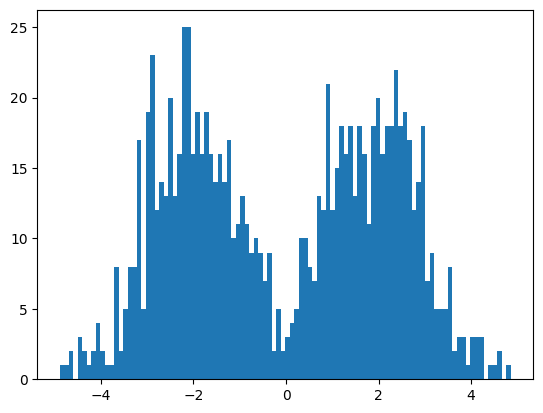

In [11]:
import matplotlib.pyplot as plt

X = np.random.normal(loc=0, scale=1, size=1000) + 2*(2*np.random.binomial(n=1, p=0.5, size=1000)-1)
plt.hist(X, bins = 100)

In [15]:
density, grid, bandwidth = kde1d(X)

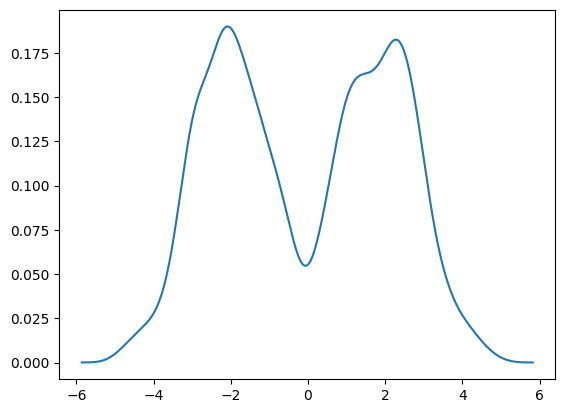

In [17]:
plt.plot(grid, density)